[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/image-retrieval/clip-object-detection/zero-shot-object-detection-clip.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/image-retrieval/clip-object-detection/zero-shot-object-detection-clip.ipynb)

# Zero Shot Object Localization and Detection with OpenAI's CLIP


The astonishing rise of multi-modal models has made the impossible possible across various domains and tasks. One of those is zero-shot object detection and localization.

“Zero-shot” means applying a model without the need for fine-tuning. Meaning we take a multi-modal model and use it to detect images in one domain, then switch to another entirely different domain without the model seeing a single training example from the new domain.

In [1]:
!pip install datasets torch transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 7.1 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


### Download the dataset

Let's start by downloading the dataset. We are using the <a ref= https://huggingface.co/datasets/jamescalam/image-text-demo> image-text-demo </a> from HuggingFace.

In [2]:
from datasets import load_dataset #pip install datasets

data = load_dataset(
    "jamescalam/image-text-demo",
    split="train",
    revision="180fdae"
)
data

Generating train split: 0 examples [00:00, ? examples/s]

Dataset image-text-demo downloaded and prepared to /root/.cache/huggingface/datasets/jamescalam___image-text-demo/default/0.0.0/83e33802f1af183872ab59b5bf8b7ae25968f4e294f8529fdae035f54b9a5abc. Subsequent calls will reuse this data.


Dataset({
    features: ['text', 'image'],
    num_rows: 21
})

The dataset includes 21 labelled images. We chose the 3rd image in the dataset, *butterfly landing on the nose of a cat*, to perform our object localization task. Let's have a look at it.

In [3]:
# image
data[2]['image']

### Break Image into Equal Patches

The first step consists of transforming our image into a tensor.

In [ ]:
from torchvision import transforms

# transform the image into tensor
transform = transforms.ToTensor()

img = transform(data[2]["image"])
img.data.shape

The generated tensor has $3$ color channels, a height of $5184$, and width of $3456$ ($5184x3456 pixels$). We now want to add an extra dimension, which will be needed for later calculations. We can use the `unfold` function.

In [ ]:
# add extra dimension for later calculations
patches = img.data.unfold(0,3,3)
patches.shape

We can now break the image into patches. More precisely, we want to break the image into $256x256$ pixels patches. We start by breaking it horizontally, meaning that we will end up with an image composed of $20$ patches of $256$ pixels in height, and $1$ patch of $3456$ pixels in width.

In [ ]:
# break the image into patches (in height dimension)
patch = 256

patches = patches.unfold(1, patch, patch)
patches.shape

We can visualize it below:

In [ ]:
import matplotlib.pyplot as plt

X = patches.shape[1]

fig, ax = plt.subplots(X, 1, figsize=(40, 26))
# loop through each strip and display
for x in range(X):
    ax[x].imshow(patches[0, x].permute(2, 0, 1))
    ax[x].axis("off")
fig.tight_layout()
plt.show()

We can now use the `unfold` function again to break the image vertically. After this operation, we will get an image composed of $20x13$ patches of $256x256$ pixels. 

In [ ]:
# break the image into patches (in width dimension)
patches = patches.unfold(2, patch, patch)
patches.shape

We can visualize it below:

In [ ]:
import matplotlib.pyplot as plt

X = patches.shape[1]
Y = patches.shape[2]

fig, ax = plt.subplots(X, Y, figsize=(Y*2, X*2))
for x in range(X):
    for y in range(Y):
        ax[x, y].imshow(patches[0, x, y].permute(1, 2, 0))
        ax[x, y].axis("off")
fig.tight_layout()
plt.show()

### Process Patches using CLIP

The first step is done. We are now almost ready to process those patches using CLIP. Before doing it, we might want to work through these patches by grouping them into a 6x6 window.

<center><div> <img src="https://raw.githubusercontent.com/pinecone-io/examples/master/learn/image-retrieval/clip-object-detection/assets/window.png" alt="Drawing" style="width:300px;"/></div> </center> 

Let's visualize the first patch.

In [ ]:
import torch

# set the 6x6 window
window = 6

big_patch = torch.zeros(patch*window, patch*window, 3)
patch_batch = patches[0][:window][:window]

# visualize patch
for y in range(window):
    for x in range(window):
        big_patch[y*patch:(y+1)*patch, x*patch:(x+1)*patch, :] = patch_batch[y, x].permute(1, 2, 0)

plt.imshow(big_patch)
plt.show()

In [ ]:
patches.shape

This is now a patch consisting of 6x6 smaller patches.

We can repeat this process by "sliding" the 6x6 window over the full image. We set the stride, i.e., the number of steps the window moves, to $1$.

In [ ]:
window = 6
stride = 1

# window slides from top to bottom
for Y in range(0, patches.shape[1]-window+1, stride):
    # window slides from left to right
    for X in range(0, patches.shape[2]-window+1, stride):
        # initialize an empty big_patch array
        big_patch = torch.zeros(patch*window, patch*window, 3)

        # this gets the current batch of patches that will make big_batch
        patch_batch = patches[0, Y:Y+window, X:X+window]
        # loop through each patch in current batch
        for y in range(patch_batch.shape[1]):
            for x in range(patch_batch.shape[0]):
                # add patch to big_patch
                big_patch[
                    y*patch:(y+1)*patch, x*patch:(x+1)*patch, :
                ] = patch_batch[y, x].permute(1, 2, 0)
        # display current big_patch
        plt.imshow(big_patch)
        plt.show()

We need now to process these through CLIP and calculate the similarity between the patch and a prompt. Our first prompt will be `"a fluffy cat"`. Let's first define our processor and model CLIP and move it to device, if possible. 

In [ ]:
from transformers import CLIPProcessor, CLIPModel
import torch

# define processor and model
model_id = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id)

# move model to device if possible
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)
print(device)

Now, we can add a step to the previous operation, i.e., we calculate similarity scores for each patch (`scores`) and the number of time the window slides over each patch (`runs`). To do that, we are trasmitting to the CLIP model the image, and the prompt, which is "a fluffy cat".

In [ ]:
window = 6
stride = 1

scores = torch.zeros(patches.shape[1], patches.shape[2])
runs = torch.ones(patches.shape[1], patches.shape[2])

for Y in range(0, patches.shape[1]-window+1, stride):
    for X in range(0, patches.shape[2]-window+1, stride):
        big_patch = torch.zeros(patch*window, patch*window, 3)
        patch_batch = patches[0, Y:Y+window, X:X+window]
        for y in range(window):
            for x in range(window):
                big_patch[
                    y*patch:(y+1)*patch, x*patch:(x+1)*patch, :
                ] = patch_batch[y, x].permute(1, 2, 0)
        # we preprocess the image and class label with the CLIP processor
        inputs = processor(
            images=big_patch,  # big patch image sent to CLIP
            return_tensors="pt",  # tell CLIP to return pytorch tensor
            text="a fluffy cat",  # class label sent to CLIP
            padding=True
        ).to(device) # move to device if possible

        # calculate and retrieve similarity score
        score = model(**inputs).logits_per_image.item()
        # sum up similarity scores from current and previous big patches
        # that were calculated for patches within the current window
        scores[Y:Y+window, X:X+window] += score
        # calculate the number of runs on each patch within the current window
        runs[Y:Y+window, X:X+window] += 1

We then want to divide the total score (`scores`) by the number of time the window slided over the patch (`runs`) to get an average score for each patch.

In [ ]:
import numpy as np 

# average score for each patch
scores /= runs

The initial visual is not very useful...

In [ ]:
# transform the patches tensor 
adj_patches = patches.squeeze(0).permute(3, 4, 2, 0, 1)
# normalize scores
scores = (
    scores - scores.min()) / (scores.max() - scores.min()
)
# multiply patches by scores
adj_patches = adj_patches * scores
# rotate patches to visualize
adj_patches = adj_patches.permute(3, 4, 2, 0, 1)

Y = adj_patches.shape[0]
X = adj_patches.shape[1]

fig, ax = plt.subplots(Y, X, figsize=(X*.5, Y*.5))
for y in range(Y):
    for x in range(X):
        ax[y, x].imshow(adj_patches[y, x].permute(1, 2, 0))
        ax[y, x].axis("off")
        ax[y, x].set_aspect('equal')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

The resulting tensor is characterized by a smooth gradient of scores and little-to-no impact from the scores on our visual. That is why (1) we are going to clip the score's interval edges for each patch so that they are around the average score, and (2) normalize scores for each patch. 

Using the `numpy.clip()` function, we can set all the scores below the average score equal to $0$ while keeping those higher than the average score as they are.

We are running the same operation 3 times as it seems to give us better results.

In [ ]:
# clip the scores' interval edges
for _ in range(1):
    scores = np.clip(scores-scores.mean(), 0, np.inf)

scores

After, we normalize the scores using the min-max normalization. For every tensor, the minimum value is transformed into a 0, the maximum value into a 1, and every other value into a decimal between 0 and 1.

In [ ]:
# normalize scores
scores = (
    scores - scores.min()) / (scores.max() - scores.min()
)
scores

### Visualize Results

These scores are telling us if a given patch contains "a fluffy cat" or not. The higher the score, the more the probability that the cat is localized in that patch. 

We now want to visualize those scores, i.e., the localized object, on the original image. Scores equal to zero will be represented by black patches, so that the localized object can be clearly seen.

To do that, we can multiply our scores by the patches. This requires that scores and patches have the same shape.

In [ ]:
scores.shape, patches.shape

Given they do not have the same shape, we can transform the patches shape using `squeeze` and `permute`. Squeeze reduce the dimensionality, while permute rotates the tensor.

In [ ]:
# transform the patches tensor 
adj_patches = patches.squeeze(0).permute(3, 4, 2, 0, 1)
adj_patches.shape

We can now multiply patches to scores.

In [ ]:
# multiply patches by scores
adj_patches = adj_patches * scores

Before plotting the localized object, we can rotate the patch tensor again to make our life easier ahead. 

In [ ]:
# rotate patches to visualize
adj_patches = adj_patches.permute(3, 4, 2, 0, 1)
adj_patches.shape

We can now visualize the localized object. We are expecting to visualize the cat only.

In [ ]:
Y = adj_patches.shape[0]
X = adj_patches.shape[1]

fig, ax = plt.subplots(Y, X, figsize=(X*.5, Y*.5))
for y in range(Y):
    for x in range(X):
        ax[y, x].imshow(adj_patches[y, x].permute(1, 2, 0))
        ax[y, x].axis("off")
        ax[y, x].set_aspect('equal')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

It worked pretty well! 

Now let's do the same for butterfly... in this case, the text trasmitted to the CLIP model will be "a butterfly".

In [ ]:
window = 6
stride = 1

scores = torch.zeros(patches.shape[1], patches.shape[2])
runs = torch.ones(patches.shape[1], patches.shape[2])

for Y in range(0, patches.shape[1]-window, stride):
    for X in range(0, patches.shape[2]-window, stride):
        big_patch = torch.zeros(patch*window, patch*window, 3)
        patch_batch = patches[0, Y:Y+window, X:X+window]
        for y in range(window):
            for x in range(window):
                big_patch[y*patch:(y+1)*patch, x*patch:(x+1)*patch, :] = patch_batch[y, x].permute(1, 2, 0)
        inputs = processor(
            images=big_patch,
            return_tensors="pt",
            text="a butterfly",
            padding=True
        ).to(device)
        score = model(**inputs).logits_per_image.item()
        scores[Y:Y+window, X:X+window] += score
        runs[Y:Y+window, X:X+window] += 1

In [ ]:
scores /= runs
for _ in range(3):
    scores = np.clip(scores-scores.mean(), 0, np.inf)
# normalize scores
scores = (scores - scores.min()) / (scores.max() - scores.min())

In [ ]:
# adjust patches
adj_patches = patches.squeeze(0).permute(3, 4, 2, 0, 1) * scores
adj_patches = adj_patches.permute(3, 4, 2, 0, 1)

In [ ]:
Y = adj_patches.shape[0]
X = adj_patches.shape[1]

fig, ax = plt.subplots(Y, X, figsize=(X*.5, Y*.5))
for y in range(Y):
    for x in range(X):
        ax[y, x].imshow(adj_patches[y, x].permute(1, 2, 0))
        ax[y, x].axis("off")
        ax[y, x].set_aspect('equal')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## CLIP for Object Detection

Localization is one step towards object detection, where we might expect to detect multiple objects.

We can extend our current localization code quite easily to achieve this, we just add an extra layer of logic. But, before we do anything, we need to rethink our localization visual — this would be hard to represent when displaying two or more objects.

The typical approach to this is to create a "bounding box".

The scores we are using are from the last run, with which we localized the butterly. Therefore, we are going to build the a bounding box around the butterfly first. We want the bounding box to focus as much as possible on the butterly only, nothing else.

Scores higher than $0.5$ seem to give us a more precise bounding box. We have then defined 'detection', which gives us *True* when the score is higher than $0.5$ (i.e.,non-zero positions), and *False* otherwise. 

In [ ]:
# scores higher than 0.5
detection = scores > 0.5

We can now detect the non-zero *positions* with the `np.nonzero` function.  These represent the co-ordinates of our patches with scores $>0.5$. 

In [ ]:
# non-zero positions
np.nonzero(detection)

The first column represents non-zero row positions, while the second column non-zero column positions. We can visualize the above co-ordinates as follows:


<center><div> <img src="https://raw.githubusercontent.com/pinecone-io/examples/master/learn/image-retrieval/clip-object-detection/assets/detection-coordinates.png" alt="Drawing" style="width:300px;"/></div> </center> 
<center><small>Co-ordinates of patches with similarity score > 0.5.</small></center>

The bounding box we want to design, will be around the area of interest.
<center><div> <img src="https://raw.githubusercontent.com/pinecone-io/examples/master/learn/image-retrieval/clip-object-detection/assets/bounding-box.png" alt="Drawing" style="width:300px;"/></div> </center> 
<center><small>Bounding box.</small></center>

We can build it by calculating its corners, which correspond to the minimum and maximum $x$ and $y$ co-ordinates, i.e., $(x_{min}, y_{min})$, $(x_{max}, y_{min})$, $(x_{min}, y_{max})$, and $(x_{max}, y_{max})$.

<center><div> <img src="https://raw.githubusercontent.com/pinecone-io/examples/master/learn/image-retrieval/clip-object-detection/assets/bounding-coordinates.png" alt="Drawing" style="width:300px;"/></div> </center> 
<center><small>Bounding box corners' co-ordinates.</small></center>

In [ ]:
y_min, y_max = (
    np.nonzero(detection)[:,0].min().item(),
    np.nonzero(detection)[:,0].max().item()+1
)
y_min, y_max

In [ ]:
x_min, x_max = (
    np.nonzero(detection)[:,1].min().item(),
    np.nonzero(detection)[:,1].max().item()+1
)
x_min, x_max

These give us the bounding box corner co-ordinates based on patches rather than pixel values. To get the pixel co-ordinates we need to multiply by the `patch` size.

In [ ]:
y_min *= patch
y_max *= patch
x_min *= patch
x_max *= patch
x_min, y_min

We use `(y_max - y_min)` and `(x_max - x_min)` to calculate the height and width of the bounding box respectively...

<center><div> <img src="https://raw.githubusercontent.com/pinecone-io/examples/master/learn/image-retrieval/clip-object-detection/assets/box-height-width.png" alt="Drawing" style="width:300px;"/></div> </center> 
<center><small>Height and width calculations.</small></center>


In [ ]:
height = y_max - y_min
width = x_max - x_min

height, width

Given our patches are $256x256$ pixels, we obtain a total height and width of $256*8=2048$ and $256*4=1024$ pixels, respectively. 

We should be now be able to visualize the bounding box on our image. We are going to use 'matplotlib'. This need the image's color channel to be as last in the image's shape.

In [ ]:
# image shape
img.data.numpy().shape

In our case, this is in the first position. We then need to move it to end. We are using 'moveaxis' to do that.

In [ ]:
# move color channel to final dim
image = np.moveaxis(img.data.numpy(), 0, -1)
image.shape

We can now plot the image.

In [ ]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(Y*0.5, X*0.5))

ax.imshow(image)

# Create a Rectangle patch
rect = patches.Rectangle(
    (x_min, y_min), width, height,
    linewidth=3, edgecolor='#FAFF00', facecolor='none'
)

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

We can repeat this process for a number of objects that we'd like CLIP to detect. let's put everything we've done so far in a few helper functions, then create a new function called `detect` to handle the detection of multiple objects and visualization of the bounding boxes.

In [ ]:
from tqdm.auto import tqdm
import matplotlib.patches as patches

colors = ['#FAFF00', '#8CF1FF']

def get_patches(img, patch_size=256):
    # add extra dimension for later calculations
    img_patches = img.data.unfold(0,3,3)
    # break the image into patches (in height dimension)
    img_patches = img_patches.unfold(1, patch_size, patch_size)
    # break the image into patches (in width dimension)
    img_patches = img_patches.unfold(2, patch_size, patch_size)
    return img_patches

def get_scores(img_patches, prompt, window=6, stride=1):
    # initialize scores and runs arrays
    scores = torch.zeros(img_patches.shape[1], img_patches.shape[2])
    runs = torch.ones(img_patches.shape[1], img_patches.shape[2])

    # iterate through patches
    for Y in range(0, img_patches.shape[1]-window+1, stride):
        for X in range(0, img_patches.shape[2]-window+1, stride):
            # initialize array to store big patches
            big_patch = torch.zeros(patch*window, patch*window, 3)
            # get a single big patch
            patch_batch = img_patches[0, Y:Y+window, X:X+window]
            # iteratively build all big patches
            for y in range(window):
                for x in range(window):
                    big_patch[y*patch:(y+1)*patch, x*patch:(x+1)*patch, :] = patch_batch[y, x].permute(1, 2, 0)
            inputs = processor(
                images=big_patch, # image trasmitted to the model
                return_tensors="pt", # return pytorch tensor
                text=prompt, # text trasmitted to the model
                padding=True
            ).to(device) # move to device if possible

            score = model(**inputs).logits_per_image.item()
            # sum up similarity scores
            scores[Y:Y+window, X:X+window] += score
            # calculate the number of runs 
            runs[Y:Y+window, X:X+window] += 1
    # calculate average scores
    scores /= runs
    # clip scores
    for _ in range(3):
        scores = np.clip(scores-scores.mean(), 0, np.inf)
    # normalize scores
    scores = (scores - scores.min()) / (scores.max() - scores.min())
    return scores

def get_box(scores, patch_size=256, threshold=0.5):
    detection = scores > threshold
    # find box corners
    y_min, y_max = np.nonzero(detection)[:,0].min().item(), np.nonzero(detection)[:,0].max().item()+1
    x_min, x_max = np.nonzero(detection)[:,1].min().item(), np.nonzero(detection)[:,1].max().item()+1
    # convert from patch co-ords to pixel co-ords
    y_min *= patch_size
    y_max *= patch_size
    x_min *= patch_size
    x_max *= patch_size
    # calculate box height and width
    height = y_max - y_min
    width = x_max - x_min
    return x_min, y_min, width, height

def detect(prompts, img, patch_size=256, window=6, stride=1, threshold=0.5):
    # build image patches for detection
    img_patches = get_patches(img, patch_size)
    # convert image to format for displaying with matplotlib
    image = np.moveaxis(img.data.numpy(), 0, -1)
    # initialize plot to display image + bounding boxes
    fig, ax = plt.subplots(figsize=(Y*0.5, X*0.5))
    ax.imshow(image)
    # process image through object detection steps
    for i, prompt in enumerate(tqdm(prompts)):
        scores = get_scores(img_patches, prompt, window, stride)
        x, y, width, height = get_box(scores, patch_size, threshold)
        # create the bounding box
        rect = patches.Rectangle((x, y), width, height, linewidth=3, edgecolor=colors[i], facecolor='none')
        # add the patch to the Axes
        ax.add_patch(rect)
    plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]

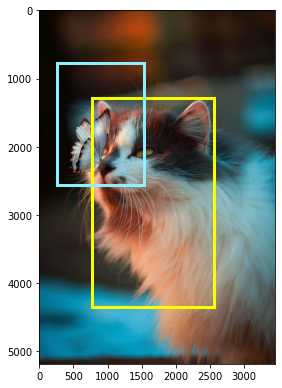

In [39]:
detect(["a cat", "a butterfly"], img, window=4, stride=1)

---